In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.utils import (
    read_genbank_ref, calculate_mutspec, CodonAnnotation, 
    possible_codons, possible_sbs12, possible_sbs192,
)
from mutspec.utils.annot import mutations_summary, translator, rev_comp, lbl2lbl_id, lbl_id2lbl
from mutspec.utils.draw import plot_mutspec12, plot_mutspec192

sns.set_style()

Format is self-explanatory. It is reasonalbe to apply common logic filters: (i) in both ancestral and derived 5 nucleotide windows there are only A T G C (ii) only Syn (iii) may be you have more filters..

first == ancestral node; second == derived node. if derived node consists of number only it means this node is internal (if there are Letters - external). For now I recomend to work with ALL nodes, but in the near future we will ask the same question (12Syn, 192Syn) separately for internal nodes and separately for external. So it is good to keep it in the pocket.

## Load human global tree mutation dataset (observed)

In [2]:
path_to_muts = "../data/external/fulltreeCodons.csv"
if not os.path.exists(path_to_muts):
    path_to_muts = "https://raw.githubusercontent.com/polarsong/mtDNA_mutspectrum/human-global-tree/Body/3Results/fulltreeCodons.csv"
muts = pd.read_csv(path_to_muts, sep=";")

muts.rename(columns={"synonymous": "is_syn"}, inplace=True)
muts["is_syn"] = muts["is_syn"].map({"non-synonymous": 0, "synonymous": 1}).astype(np.float16)
muts["is_leaf"] = (~muts.second.str.contains("^\d+$")).astype(np.int8)

muts.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,is_syn,ancestral_aa,derived_aa,note,is_leaf
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,1
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding,1
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,0.0,Asn,Asp,normal,1
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,2.0,0.0,Arg,Ambiguous,normal,1
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,3.0,1.0,Pro,Pro,normal,1


### Explore mut dataset

In [3]:
len(set(muts["first"]).union(set(muts["second"])))

105980

In [4]:
muts.gene_info.value_counts()

D-loop_1          114760
D-loop_2           78661
mRNA_ND5           51977
mRNA_CYTB          37105
mRNA_COX1          35396
mRNA_ND4           33257
mRNA_ND2           31506
mRNA_ND1           26847
mRNA_ATP6          23331
rRNA_RNR2          20396
mRNA_COX3          20272
mRNA_COX2          17713
rRNA_RNR1          16983
mRNA_ND6           15439
mRNA_ND3           10153
mRNA_ND4L           5820
mRNA_ATP8           5177
tRNA_TRNT           4416
tRNA_TRNC           1842
mRNA_ATP8&ATP6      1787
tRNA_TRNS2          1534
tRNA_TRNH           1459
Spacer3             1424
tRNA_TRNA           1394
tRNA_TRNF           1367
tRNA_TRNG           1367
tRNA_TRNW           1294
Spacer7             1250
tRNA_TRNR           1244
tRNA_TRNQ           1229
tRNA_TRNK           1147
tRNA_TRNE           1025
tRNA_TRND           1022
None                 967
tRNA_TRNL2           836
tRNA_TRNM            772
tRNA_TRNI            713
tRNA_TRNP            661
tRNA_TRNS1           560
Spacer4              511


## Filter mutations

In [5]:
muts_filtered = muts[
    (muts.is_syn == 1) &  # (ii) only Syn
    (muts.ancestor.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &  #  (i) in both ancestral and derived 5 nucleotide windows there are only A T G C
    (muts.descendant.str.contains("[acgt]{2}[ACGT][acgt]{2}")) & 
    (~muts.gene_info.str.contains("ND6"))
]
muts_filtered["Mut"] = muts_filtered["ancestor"].str.get(1) + "[" + muts_filtered["ancestor"].str.get(2) + ">" + muts_filtered["descendant"].str.get(2) + "]" + muts_filtered["descendant"].str.get(3)
muts_filtered["Mut"] = muts_filtered["Mut"].str.upper()
print(muts_filtered.shape)
muts_filtered.head()

(103672, 16)


,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,is_syn,ancestral_aa,derived_aa,note,is_leaf,Mut
14,17837,EU_IT_0648,3642,3482,gaAcc,gaGcc,G,mRNA_ND1,3306.0,3.0,1.0,Glu,Glu,normal,1,A[A>G]C
20,6484,EU_GB_0203,8826,8598,ttTta,ttCta,C,mRNA_ATP6,8526.0,3.0,1.0,Phe,Phe,normal,1,T[T>C]T
22,6484,EU_GB_0203,14184,13942,caCaa,caTaa,C,mRNA_ND5,12336.0,3.0,1.0,His,His,normal,1,A[C>T]A
26,15298,11475,12801,12560,caAct,caGct,G,mRNA_ND5,12336.0,3.0,1.0,Gln,Gln,normal,0,A[A>G]C
29,33133,7947,3555,3395,taCat,taTat,T,mRNA_ND1,3306.0,3.0,1.0,Tyr,Tyr,normal,0,A[C>T]A


### Explore filtered mut dataset

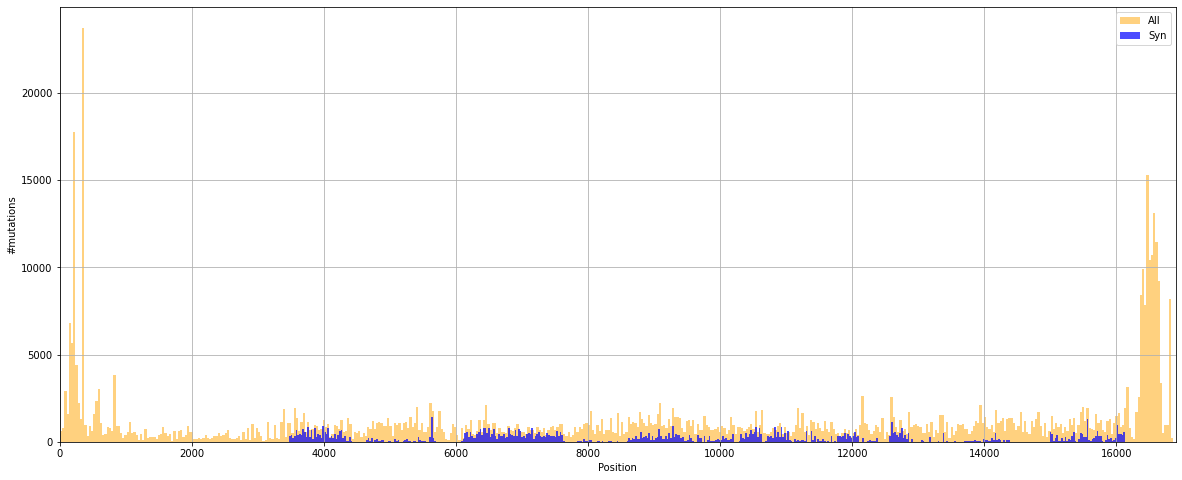

In [75]:
plt.figure(figsize=(20, 8))
muts.position.hist(bins=500, alpha=0.5, label="All", color="orange")
muts_filtered.position.hist(bins=500, alpha=0.7, label="Syn", color="b")
# plt.yscale("log")
plt.xlim(0, 16900)
plt.xlabel("Position")
plt.ylabel("#mutations")
plt.legend()
plt.show()

In [76]:
muts_filtered.pos_in_codon.value_counts()

3.0    96579
1.0     7089
2.0        4
Name: pos_in_codon, dtype: int64

In [77]:
muts_filtered.is_leaf.value_counts()

1    62786
0    40886
Name: is_leaf, dtype: int64

In [78]:
muts_filtered.derived_aa.value_counts()

Leu     20774
Ser      8792
Pro      8003
Gly      6523
Ala      5822
Stop     5670
Thr      5453
Tyr      4576
Glu      4557
Ile      4303
His      4246
Met      4022
Val      3664
Trp      3330
Gln      3187
Asn      2992
Lys      2778
Phe      2688
Asp      1095
Arg       701
Cys       496
Name: derived_aa, dtype: int64

In [79]:
muts_filtered.gene_info.value_counts()

mRNA_COX1         26135
mRNA_ND1          15704
mRNA_CYTB         12718
mRNA_ND5           9459
mRNA_ND4           9194
mRNA_ATP6          8216
mRNA_ND3           6160
mRNA_ND4L          4744
mRNA_COX3          4455
mRNA_ND2           4353
mRNA_ATP8          1190
mRNA_COX2           926
mRNA_ATP8&ATP6      414
mRNA_ND4L&ND4         4
Name: gene_info, dtype: int64

In [86]:
muts_filtered.Mut.value_counts().head(10)

A[G>A]C    4394
C[T>C]T    4348
A[A>G]C    4236
C[C>T]T    4076
A[T>C]T    4012
A[C>T]T    3746
C[G>A]C    3201
T[G>A]C    3135
T[A>G]C    2993
C[A>G]C    2978
Name: Mut, dtype: int64

In [85]:
muts_filtered.Mut.value_counts().tail(10)

G[G>T]A    5
G[G>C]T    4
G[T>G]A    4
T[C>G]G    4
G[G>C]C    4
G[C>G]T    4
C[G>C]G    4
G[A>T]T    2
G[T>A]A    2
G[T>A]T    2
Name: Mut, dtype: int64

## Calculate expected mutations for Human mtDNA (all, syn, genes)

In [6]:
coda = CodonAnnotation(2)

In [7]:
# Read reference genbank
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb)
print(Ref.shape)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


In [8]:
ProtRef = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]
ProtRef

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
3306,3307,A,CAT,1,CDS,ND1,1,1,ATA
3307,3308,T,ATA,1,CDS,ND1,2,2,ATA
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA
3309,3310,C,ACC,1,CDS,ND1,4,1,CCC
3310,3311,C,CCC,1,CDS,ND1,5,2,CCC
...,...,...,...,...,...,...,...,...,...
15882,15883,G,GGG,1,CDS,CYTB,1137,3,TGG
15883,15884,G,GGC,1,CDS,CYTB,1138,1,GCC
15884,15885,C,GCC,1,CDS,CYTB,1139,2,GCC
15885,15886,C,CCT,1,CDS,CYTB,1140,3,GCC


In [9]:
exp_muts12 = dict()
exp_muts192 = dict()
for gene, gtable in ProtRef[ProtRef.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=["syn"])
    for lbl in gene_exp_muts12:
        if lbl not in exp_muts12:
            exp_muts12[lbl] = defaultdict(int)
            exp_muts192[lbl] = defaultdict(int)

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[lbl][sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[lbl][sbs] += _cnt

        if lbl == "syn":
            exp_muts12[lbl + "_" + gene] = gene_exp_muts12[lbl]
            exp_muts192[lbl + "_" + gene] = gene_exp_muts192[lbl]

for lbl in ["D-loop", "rRNA", "tRNA"]:
    f1, f2 = coda.collect_exp_mut_freqs(Ref[Ref.Type == lbl]["Nuc"].values, ["all"])
    exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

lbl = "ExDloop"
f1, f2 = coda.collect_exp_mut_freqs(Ref[(~Ref.Type.isin(["D-loop", "misc_feature"]))]["Nuc"].values, ["all"])
exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

In [10]:
pd.DataFrame(exp_muts192).sort_index()

,syn,syn_ATP6,syn_ATP8,syn_COX1,syn_COX2,syn_COX3,syn_CYTB,syn_ND1,syn_ND2,syn_ND3,syn_ND4,syn_ND4L,syn_ND5,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,113,78.0,494
A[A>C]C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,84,51.0,463
A[A>C]G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,69,40.0,196
A[A>C]T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,50,41.0,355
A[A>G]A,78.0,5.0,3.0,4.0,7.0,4.0,9.0,4.0,9.0,4.0,9.0,NaN,20.0,30,113,78.0,494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T[T>C]T,47.0,2.0,NaN,6.0,3.0,9.0,2.0,1.0,5.0,5.0,9.0,1.0,4.0,20,32,44.0,231
T[T>G]A,34.0,4.0,1.0,3.0,3.0,1.0,NaN,3.0,4.0,1.0,3.0,NaN,11.0,18,56,52.0,311
T[T>G]C,28.0,2.0,NaN,3.0,1.0,2.0,4.0,2.0,6.0,NaN,3.0,1.0,4.0,15,26,27.0,293
T[T>G]G,11.0,NaN,NaN,1.0,2.0,NaN,3.0,2.0,NaN,NaN,2.0,NaN,1.0,12,22,14.0,104


## Calculate MutSpec

In [14]:
muts_filtered["Label"] = 1
ms192 = calculate_mutspec(muts_filtered, exp_muts192["syn"], use_context=True)
ms12 = calculate_mutspec(muts_filtered, exp_muts12["syn"], use_context=False)

# Reverse complement of Mut (to heavy strand)
ms192["Mut"] = ms192.Mut.apply(rev_comp)
ms12["Mut"] = ms12.Mut.str.translate(translator)
ms192.sort_values("Mut", inplace=True)
ms12.sort_values("Mut", inplace=True)

ms12.to_csv("../data/processed/human_global_tree_mutspec12syn.csv", index=None)
ms192.to_csv("../data/processed/human_global_tree_mutspec192syn.csv", index=None)

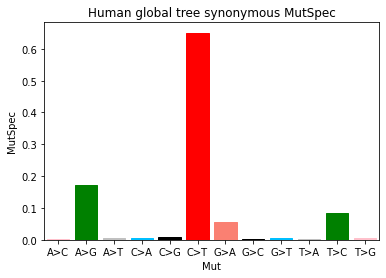

In [16]:
plot_mutspec12(ms12, title="Human global tree synonymous MutSpec", savepath="../figures/human_global_tree_mutspec12syn.pdf")

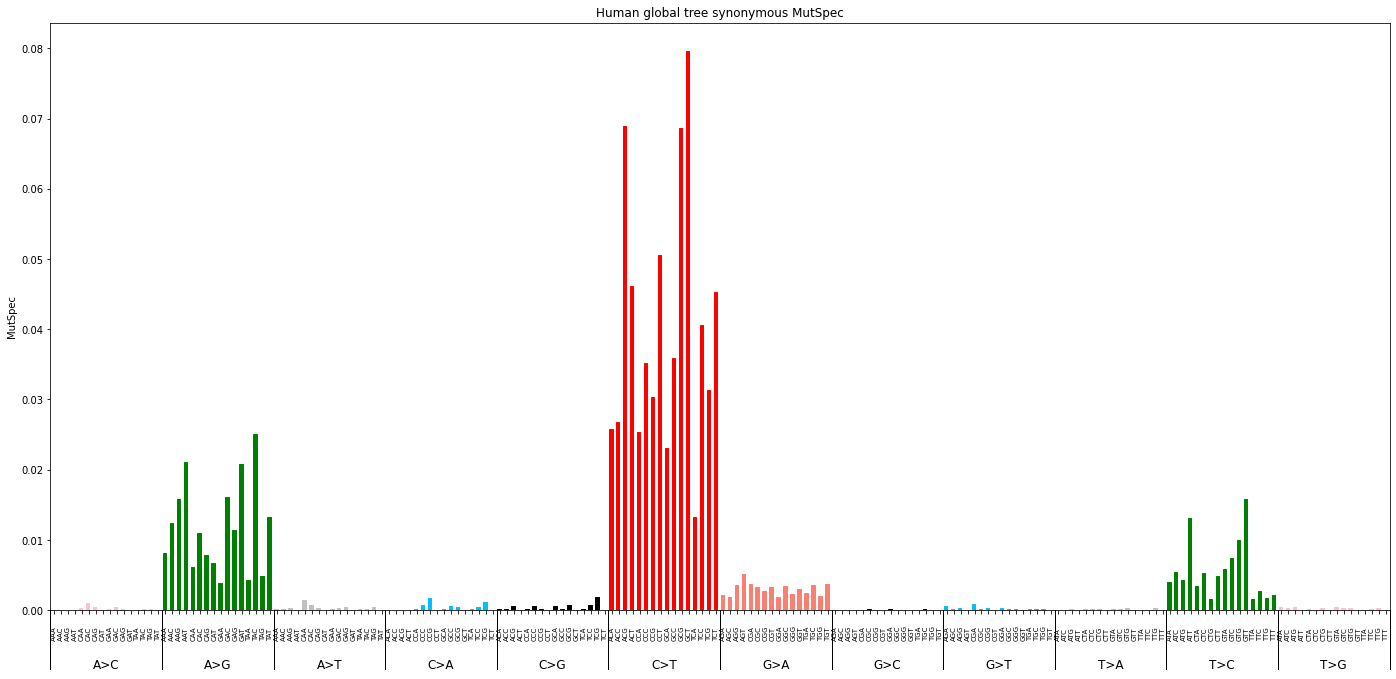

In [17]:
plot_mutspec192(ms192, title="Human global tree synonymous MutSpec", filepath="../figures/human_global_tree_mutspec192syn.pdf")